In [212]:
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from umap import UMAP
import plotly.express as px

from scipy.stats import pointbiserialr


In [213]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)

# 1. Analiza DF niezaanotowanego


In [214]:
df_tweets = pd.read_pickle('./bertopic_data/tweets_no_anotation.pkl').reset_index().rename(columns={'index': 'New_Index_Column'}).drop(columns='New_Index_Column')
print('Has any index duplicated values?')
print(df_tweets.index.duplicated().any())
df_tweets

Has any index duplicated values?
False


,tweet_id,username,is_retweet,is_pinned,date,text,replies,retweets,likes,m,processed_text,nt,NOUN,ADV,ADP,PROPN,ADJ,VERB,NUM,DET,AUX,PRON,SCONJ,PART,CCONJ,X,PUNCT,SPACE,SYM,INTJ,topic,TextBlob_Subjectivity,TextBlob_Polarity,sentiment_herbert
0,1720011855823765544,trzaskowski_,True,False,2023-11-02 09:35:00,wiadomość prosto od mera kijowa vitaliy_klychk...,457.0,399.0,3461.0,2023-11-02,,63,21.0,6.0,10.0,1.0,13.0,4.0,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0,1
1,1719636816771285367,pomaska,True,False,2023-11-01 08:45:00,pis jest znany z przecinania wstęgi po kilka r...,469.0,224.0,1034.0,2023-11-01,,37,15.0,0.0,5.0,0.0,4.0,2.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0
2,1719378456910221417,donaldtusk,True,False,2023-10-31 15:39:00,meldunek od serca,2253.0,2383.0,11381.0,2023-11-01,,3,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0,1
3,1718925236274336067,pomaska,True,False,2023-10-30 09:38:00,drastyczny wzrost ceny hurtowej oleju napędowe...,155.0,180.0,562.0,2023-10-30,,51,20.0,0.0,7.0,1.0,6.0,6.0,0.0,1.0,2.0,1.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0
4,1716753316548432358,pomaska,True,False,2023-10-24 09:47:00,transmisja konferencji prasowej opozycji w tvp...,549.0,388.0,3479.0,2023-10-24,,13,4.0,1.0,1.0,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19097,1714553353806426149,m_gdula,False,False,2023-10-18 08:05:00,karolu bardzo dziękuje za twoje zaangażowanie ...,NaN,0.0,2.0,2023-10-18,,8,3.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0,1
19098,1714553135308341274,m_gdula,False,False,2023-10-18 08:04:00,dziękuje ci serdecznie to bardzo ważne dla mni...,NaN,0.0,1.0,2023-10-18,,11,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0,1
19099,1714552951920820558,m_gdula,False,False,2023-10-18 08:04:00,dziękuje panie franku teraz na pewno trzeba wa...,NaN,0.0,3.0,2023-10-18,,22,6.0,4.0,3.0,0.0,3.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,1
19100,1714549182587904069,urbaniak_michal,False,False,2023-10-18 07:49:00,januszu dziękuję za miłe słowa życzę owocnej p...,2.0,0.0,8.0,2023-10-18,,30,10.0,0.0,6.0,1.0,4.0,4.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0,1


In [215]:
print('Is there correlation between is_retweet and the fact that the tweet text is duplicated?')
pointbiserialr(df_tweets.text.duplicated().astype(int), df_tweets.is_retweet.astype(int) ) #low p-value is the evidence of correlation dependence between duplicated text and retweet

Is there correlation between is_retweet and the fact that the tweet text is duplicated?


SignificanceResult(statistic=-0.08094121474287988, pvalue=3.873656973525072e-29)

In [216]:
print('Analysis of empty/not meaningful values:')
print('Count of NA texts:', df_tweets.text.isna().sum())
print('Count of empty texts:', (df_tweets.text == '').sum())

Analysis of empty/not meaningful values:
Count of NA texts: 0
Count of empty texts: 315


Obserwacje:

1. Są duplikaty i puste stringi w tweetach, do klasteryzacji BERTopikiem nie będą one wchodzić
2. Nie ma podstaw do stwierdzenia koleracji między duplikacją tekstu a faktem że tweet jest retweetem


In [217]:
df_tweets = df_tweets.loc[df_tweets[(df_tweets.text != '')].index] #drop tweets that have '' text
df_tweets.head(10)

,tweet_id,username,is_retweet,is_pinned,date,text,replies,retweets,likes,m,processed_text,nt,NOUN,ADV,ADP,PROPN,ADJ,VERB,NUM,DET,AUX,PRON,SCONJ,PART,CCONJ,X,PUNCT,SPACE,SYM,INTJ,topic,TextBlob_Subjectivity,TextBlob_Polarity,sentiment_herbert
0,1720011855823765544,trzaskowski_,True,False,2023-11-02 09:35:00,wiadomość prosto od mera kijowa vitaliy_klychk...,457.0,399.0,3461.0,2023-11-02,,63,21.0,6.0,10.0,1.0,13.0,4.0,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0,1
1,1719636816771285367,pomaska,True,False,2023-11-01 08:45:00,pis jest znany z przecinania wstęgi po kilka r...,469.0,224.0,1034.0,2023-11-01,,37,15.0,0.0,5.0,0.0,4.0,2.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0
2,1719378456910221417,donaldtusk,True,False,2023-10-31 15:39:00,meldunek od serca,2253.0,2383.0,11381.0,2023-11-01,,3,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0,1
3,1718925236274336067,pomaska,True,False,2023-10-30 09:38:00,drastyczny wzrost ceny hurtowej oleju napędowe...,155.0,180.0,562.0,2023-10-30,,51,20.0,0.0,7.0,1.0,6.0,6.0,0.0,1.0,2.0,1.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0
4,1716753316548432358,pomaska,True,False,2023-10-24 09:47:00,transmisja konferencji prasowej opozycji w tvp...,549.0,388.0,3479.0,2023-10-24,,13,4.0,1.0,1.0,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0
5,1716756647312277650,trzaskowski_,True,False,2023-10-24 10:00:00,panie prezydencie jaśniej się nie da jest demo...,1137.0,864.0,7150.0,2023-10-24,,30,10.0,2.0,3.0,1.0,1.0,5.0,0.0,2.0,1.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0
6,1716696741364351266,pomaska,True,False,2023-10-24 06:02:00,zrobiliśmy to dzięki wam to nasza wspaniała dr...,165.0,117.0,855.0,2023-10-24,,35,5.0,1.0,4.0,3.0,5.0,3.0,2.0,3.0,1.0,3.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,5,0.0,0.0,1
7,1716438147045679518,donaldtusk,True,False,2023-10-23 12:55:00,lucień tu był od ośmiu lat naprawdę zdziwieni,1392.0,2285.0,12211.0,2023-10-24,,8,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,-1
8,1715734741054284012,pomaska,True,False,2023-10-21 14:20:00,nikt tak dobrze nie odmienia mojego nazwiska j...,126.0,86.0,935.0,2023-10-22,,21,4.0,3.0,2.0,0.0,4.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,1
9,1715420839095451834,donaldtusk,True,False,2023-10-20 17:32:00,kaczyński co wy tam palicie przecież kopie są ...,3878.0,4291.0,34802.0,2023-10-21,,11,2.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,-1


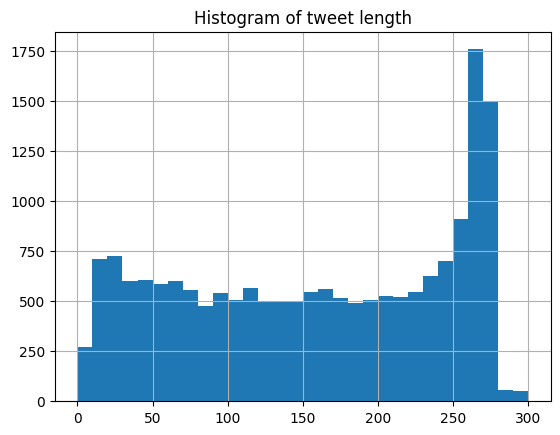

In [218]:
#plot histogram of tweet text length
n_bins = 30
ax = df_tweets.text.apply(lambda x: len(x)).hist(range=(0, 300), bins=n_bins)
ax.set_title('Histogram of tweet length')
pass

Obserwacja: gwałtowny spadek długości tweeta po ok. 250-275 znakach - zrozumiałe, Twitter ma ograniczenia na długość tekstu


In [219]:
# let's see what do tweets of specific max length look like, then drop
max_tweet_length = 30

print(f'Sample of tweets which have length less than or equal to {max_tweet_length} (total: {(df_tweets.text.apply(lambda x: len(x)) <= max_tweet_length).sum()}):\n')
for index, v in df_tweets.loc[df_tweets.text.apply(lambda x: len(x)) <= max_tweet_length].sample(50).iterrows():
    print(index, v.text)

print()

print(f'Sample of tweets which have length more than {max_tweet_length} (total: {(df_tweets.text.apply(lambda x: len(x)) > max_tweet_length).sum()}):\n')
for index, v in df_tweets.loc[df_tweets.text.apply(lambda x: len(x)) > max_tweet_length].sample(50).iterrows():
    print(index, v.text)

df_tweets.drop(index=df_tweets.loc[df_tweets.text.apply(lambda x: len(x)) <= max_tweet_length].index, inplace=True)


Sample of tweets which have length less than or equal to 30 (total: 1798):

6215 przyszłośćtopolska🇵🇱
11826 barbarzyńcy
12123 radioszczecinpl/1448822ko…
3640 pis = prl bis
3996 obliczakonfederacji
154 dobrego dnia :-)
18513 🇵🇱💪✌️👏❤️
6619 tak byłodzięki🌹
5953 nie dla przymusowej relokacji
16871 programowyul
11954 zapraszam✌️
10899 anijednejwiecej
4205 do zobaczenia✌️ marsz4czerwca
2243 kłamstawatuska część 10
2245 kłamstwatuska część 8
8095 bezpiecznapolska
14844 facebookcom/kukizpawel/post…
11131 wolnywybór
13009 ryży kłamca
6062 gratuluję
15744 temu nie można zaprzeczyć
617 tusk na deskach🤷‍♂️ tylkopis💪😊
2179 plantuska 👇
5285 tarnowskatv/artykul/17354p…
15746 tak wstał i wyszedł…
6349 ⚽️🇵🇱⚽️🇵🇱👏
12969 prezydentpolskichspraw 🙂
11383 tiktok na dziś ukraina pieski
16777 ja wolałbym nie wybierać 😎
2204 bezpiecznapolska 🇵🇱
5544 kłamstwatuska
11128 25 lat konstytucjarp
11742 skandal
969 kłamstwatuska
6705 i ja tam byłem😊
18356 tomekzimochpl/wp-content/up…
6581 polskawieśwspolnedobro
2129 wyb

Obserwacja: Tweety o niewystarczającej długości są niejednoznaczne i w związku z tym są kandydatami do usunięcia


In [220]:
print('Existing texts that are duplicated')
print()

for text in df_tweets.loc[df_tweets.text.duplicated()].text.unique():
    print(text)

Existing texts that are duplicated

stopprzymusowejrelokacji bezpiecznapolska
stopprzymusowejrelokacji 4razynie
bezpiecznapolska muremzapolskimmundurem
niedlaprzymusutuska emeryturystażowe
szacunek i pamięć walczącym o wolną polskę🇵🇱
szacunek i pamięć walczącym o wolną polskę 🇵🇱
bezpiecznapolska stopprzymusowejrelokacji
dlategoko platforma_org grupaepl
obliczakonfederacji konfabulacja
🇵🇱 15 października proszę was o głos ✒️ miejsce 4️⃣ na liście pisorgpl 🇵🇱 4gontarz 🤍❤️ bezpiecznaprzyszłośćpolaków
dawno dawno temu za górami za lasami w ten sposób swoje wypowiedzi powinien zaczynać pan donald bajkituska bo tak trzeba nazwać to co pan wypisuje na temat szalonej wyprzedaży majątku narodowego którą przecież pan zorganizował będąc premierem teraz udaje pan że ktoś inny podejmował decyzje czasem lepiej milczeć
wesprzyj moją kampanię‼️ jak możesz pomóc ➡️ zgłoś miejsce na: baner billboard plakat ➡️ zgłoś chęć pomocy w kampanii skontaktuj się ze mną: 🔗biurokonfederacjitarnowgmailcom 📞 518 401 

# 2. BERTopic na tweetach - analiza


In [221]:
df_tweets_no_dup_texts = df_tweets.drop_duplicates(subset='text')

In [222]:
representation_model = KeyBERTInspired(random_state=42)
calculate_probabilities = True # get document's topic probs for each detected topic, not just the predicted one
umap_model = UMAP(n_neighbors=30, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
nr_topics: int | str = 50
topic_model = BERTopic(language='polish', nr_topics=nr_topics, verbose=True, representation_model=representation_model, calculate_probabilities=calculate_probabilities, umap_model=umap_model)

In [223]:
topics, probs = topic_model.fit_transform(df_tweets_no_dup_texts.text)

2023-12-25 18:55:00,868 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/528 [00:00<?, ?it/s]

2023-12-25 18:55:13,764 - BERTopic - Embedding - Completed ✓
2023-12-25 18:55:13,765 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2023-12-25 18:55:23,975 - BERTopic - Dimensionality - Completed ✓
2023-12-25 18:55:23,976 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p

In [224]:
ignore_outlier = True
topic_info_df = topic_model.get_topic_info()
if (ignore_outlier):
    topic_info_df = topic_info_df.loc[topic_info_df.Topic != -1]

fig = px.histogram(y=topic_info_df['Name'], x=topic_info_df['Count'], orientation='h', title='Histogram of topic occurences' + (' (outlier topic -1 omitted)' if ignore_outlier else ''))
fig.update_layout(height=900)
fig.update_xaxes(title_text='# of Occurences')

# Update y-axis label
fig.update_yaxes(title_text='Topic name')
fig.show()

In [225]:
topic_model.visualize_barchart(top_n_topics=nr_topics if isinstance(nr_topics, int) else 50, n_words=20)

Obserwacja: Sporo tematów grupuje według różnych odmian morfologicznych tego samego wyrazu. Zdarzają się też grupowania ze względu na dziedzinę (np. homofobia, mniejszości, LGBT)


In [226]:
topic_model.visualize_documents(list(df_tweets_no_dup_texts.text), width=1366, height=768, sample=0.3, hide_annotations=True)


Obserwacja: klasteryzacja wskazała grupy tekstów, które są wizualnie separowalne w przestrzeni ukrytej. Sporo jest jednak outlierów niepasujących do żadnego klastra


In [227]:
# Using .get_document_info, we can also extract information on a document level, such as their corresponding topics, 
# probabilities, whether they are representative documents for a topic, etc.:
df_tweet_document_infos = topic_model.get_document_info(df_tweets_no_dup_texts.text)
df_tweet_document_infos

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,wiadomość prosto od mera kijowa vitaliy_klychk...,30,30_tramwajnakasprzaka_tramwaje_tramwajem_pociągów,"[tramwajnakasprzaka, tramwaje, tramwajem, poci...",[wczoraj na ul puławskiej zaczepił mnie mieszk...,tramwajnakasprzaka - tramwaje - tramwajem - po...,0.102625,False
1,pis jest znany z przecinania wstęgi po kilka r...,8,8_czołgów_zbrojeniowych_samoloty_samolotów,"[czołgów, zbrojeniowych, samoloty, samolotów, ...",[3 miesiące wystarczyło mblaszczak na zakup w ...,czołgów - zbrojeniowych - samoloty - samolotów...,0.309264,False
2,drastyczny wzrost ceny hurtowej oleju napędowe...,26,26_węgla_paliwa_benzyna_benzyny,"[węgla, paliwa, benzyna, benzyny, emisji, prąd...",[tak działa system ets i pakiet klimatyczny ue...,węgla - paliwa - benzyna - benzyny - emisji - ...,0.206091,False
3,transmisja konferencji prasowej opozycji w tvp...,13,13_mediów_media_dziennikarstwo_dziennikarzy,"[mediów, media, dziennikarstwo, dziennikarzy, ...",[najlepiej by o mediach publicznych jak najmni...,mediów - media - dziennikarstwo - dziennikarzy...,0.085104,False
4,panie prezydencie jaśniej się nie da jest demo...,3,3_wyborczej_wyborcza_wyborczych_wyborach,"[wyborczej, wyborcza, wyborczych, wyborach, wy...",[dlaczego 🗳referendum 15 października jest pot...,wyborczej - wyborcza - wyborczych - wyborach -...,0.099048,False
...,...,...,...,...,...,...,...,...
16866,karolu bardzo dziękuje za twoje zaangażowanie ...,4,4_dziękujemy_dziękuję_zapraszamy_pozdrawiam,"[dziękujemy, dziękuję, zapraszamy, pozdrawiam,...",[osiek głosuje na duda2020 bardzo dziękuję za ...,dziękujemy - dziękuję - zapraszamy - pozdrawia...,0.427300,False
16867,dziękuje ci serdecznie to bardzo ważne dla mni...,4,4_dziękujemy_dziękuję_zapraszamy_pozdrawiam,"[dziękujemy, dziękuję, zapraszamy, pozdrawiam,...",[osiek głosuje na duda2020 bardzo dziękuję za ...,dziękujemy - dziękuję - zapraszamy - pozdrawia...,0.238508,False
16868,dziękuje panie franku teraz na pewno trzeba wa...,-1,-1_polityka_opozycji_polska_polskawnaszychsercach,"[polityka, opozycji, polska, polskawnaszychser...",[znamy oficjalne wyniki wyborów my naród celuj...,polityka - opozycji - polska - polskawnaszychs...,0.096614,False
16869,januszu dziękuję za miłe słowa życzę owocnej p...,-1,-1_polityka_opozycji_polska_polskawnaszychsercach,"[polityka, opozycji, polska, polskawnaszychser...",[znamy oficjalne wyniki wyborów my naród celuj...,polityka - opozycji - polska - polskawnaszychs...,0.084742,False


In [228]:
# Let's sample some tweets with their assigned topic
for index, row in df_tweet_document_infos.sample(10).iterrows():
    print(row.Document)
    print(row.Name)
    print(row.Probability)
    print()

zainteresowanych zaprasza do wysłuchania dwóch czwartkowych audycji z moim udziałem:
-1_polityka_opozycji_polska_polskawnaszychsercach
0.7670966804990451

jedziemy | „myślę że ludzie wkrótce zatęsknią za rządami pis” mareksuski o wynikach wyborów niezaleznapl niezaleznapl/polityka/wybor…
3_wyborczej_wyborcza_wyborczych_wyborach
0.18811744361038024

kraków to tu powstanie pierwsza mobilna stacja wodorowa grupy pkn_orlen 👍
-1_polityka_opozycji_polska_polskawnaszychsercach
0.38757160810404045

to napalony wikary czy człowiek bóbr bo nie chciałbym się nabrać 😎
16_powiedział_słowa_wydawało_że
1.0

dziś w radiokoszalin o nowo zarejestrowanej partii centrumdlapl wchodzacej w skład koalicja_pl o określeniu ceny sprzedaży węgla dla samorządów o błędnej polityce cenowej energetycznych spółek skarbu państwa i o możliwej eskalacji wojny na ukrainie prk24pl/63948401/po-slowie-…
26_węgla_paliwa_benzyna_benzyny
0.30951975779233065

blokując 500 mld zł środków unijnych dla polski pisorgpl ratuje budże

Obserwacja: Próbka zaanotowanych tweetów podpowiada, że jest sporo przypadków, które są outlierami (-1). Ile ich realnie jest?


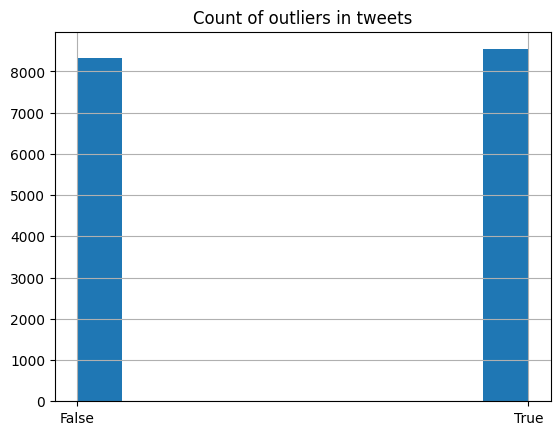

In [229]:
df_tweet_document_infos['Is_outlier'] = df_tweet_document_infos.apply(lambda x: x.Topic == -1, axis=1)
h = df_tweet_document_infos.Is_outlier.astype(str).hist()
h.set_title('Count of outliers in tweets') # type: ignore
pass

Widać, że około połowa tweetów na ten moment została uznana za outliery niepasujące do danych, jak prezentują się zatem te, które do tematów przypisano?


In [230]:
for index, row in df_tweet_document_infos[df_tweet_document_infos.Is_outlier == False].sample(20).iterrows():
    print(row.Document)
    print(row.Name)
    print(row.Probability)
    print()

mamy masterplan dla stolicy - nowestudiumwarszawy koncepcję rozwoju warszawa do 2050 r stolicy wygodnej dobrze zaplanowanej zielonej otwartej miasta w którym chce się żyć miasta przyjaznego miasta dla was i z wami chcemy ten plan realizować
48_nowecentrumwarszawy_warszawa_warszawianek_nowestudiumwarszawy
1.0

pis w kwestii praw człowieka jak i stosunku do mediów jak zwykle próbuje kopiować putina wolnemedia
10_putinowi_rosyjskimi_rosyjska_rosyjskie
0.36830287608311724

będziemy ponownie dochodzić do prawdy…
13_mediów_media_dziennikarstwo_dziennikarzy
0.07485168359765386

elity tuska i tvn panie zhołdys minister jozdoba był bardzo spokojny proszę mu nie grozić bo pan to co najwyżej może zrobić pod siebie albo w kapelusz
6_komisji_sędziowie_sędziów_sędziego
0.27976794966644347

ministrowie rolnictwa pełniący swoje urzędy w wolnej polsce ponadpolitycznie wystosowali wspólny list-apel w sprawie sytuacji w rolnictwie i jego przyszłości szczególnie w kontekście wojny na ukrainie i dalszego b

Obserwacja: Tematy nie są wykryte w sposób idealny, jednak jest to przypisanie, w którym można zaobserwować poprawnie i zgodnie z intuicją zaanotowane propozycje.


In [231]:
for _, row in topic_info_df.iterrows():
    print('Topic: ' + row.Name)
    print('Representative texts: ')
    for text in row.Representative_Docs:
        print('\t' + text)

    print()

Topic: 0_migranci_migrantów_migracyjnej_imigracji
Representative texts: 
	20 czerwca to światowy dzień uchodźcy to mogłaby – i powinna – być doskonała okazja żeby raz jeszcze przypomnieć światu o niesamowitej oddolnej niemal powszechnej akcji pomocy którą razem zbudowaliśmy w obliczu wojny za naszą wschodnią granicą jestem bezgranicznie dumny z tysięcy polek i polaków z warszawianek i warszawiaków którzy swoim zaangażowaniem uczynili ją możliwą ale nie ma takiego dorobku takiego osiągnięcia tak oczywistego dobra którego nie byłaby gotowa ubrudzić obrzydzić zmarnować obecna władza chwilę po tym jak polska pokazała swoją piękną twarz – twarz pełną empatii gotowości do niesienia pomocy ogromnej determinacji – pis znów robi wszystko żeby przyprawić naszemu krajowi wredną „gębę” na potrzeby sypiącej się kampanii w której każdy kolejny potencjalny „gamechanger” okazuje się być kapiszonem znów sięgają do przepastnej kieszeni z odrażającymi pomysłami coraz głębiej jak zwykle licząc że „ciemny 

# 3. Redukcja outlierów


In [232]:
new_topics = topic_model.reduce_outliers(df_tweets_no_dup_texts.text, topics, probabilities=probs, strategy='probabilities')

In [233]:
df_tweets_no_dup_texts['detected_topic'] = new_topics
df_tweets_no_dup_texts

,tweet_id,username,is_retweet,is_pinned,date,text,replies,retweets,likes,m,processed_text,nt,NOUN,ADV,ADP,PROPN,ADJ,VERB,NUM,DET,AUX,PRON,SCONJ,PART,CCONJ,X,PUNCT,SPACE,SYM,INTJ,topic,TextBlob_Subjectivity,TextBlob_Polarity,sentiment_herbert,detected_topic
0,1720011855823765544,trzaskowski_,True,False,2023-11-02 09:35:00,wiadomość prosto od mera kijowa vitaliy_klychk...,457.0,399.0,3461.0,2023-11-02,,63,21.0,6.0,10.0,1.0,13.0,4.0,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0,1,30
1,1719636816771285367,pomaska,True,False,2023-11-01 08:45:00,pis jest znany z przecinania wstęgi po kilka r...,469.0,224.0,1034.0,2023-11-01,,37,15.0,0.0,5.0,0.0,4.0,2.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0,8
3,1718925236274336067,pomaska,True,False,2023-10-30 09:38:00,drastyczny wzrost ceny hurtowej oleju napędowe...,155.0,180.0,562.0,2023-10-30,,51,20.0,0.0,7.0,1.0,6.0,6.0,0.0,1.0,2.0,1.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0,26
4,1716753316548432358,pomaska,True,False,2023-10-24 09:47:00,transmisja konferencji prasowej opozycji w tvp...,549.0,388.0,3479.0,2023-10-24,,13,4.0,1.0,1.0,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0,13
5,1716756647312277650,trzaskowski_,True,False,2023-10-24 10:00:00,panie prezydencie jaśniej się nie da jest demo...,1137.0,864.0,7150.0,2023-10-24,,30,10.0,2.0,3.0,1.0,1.0,5.0,0.0,2.0,1.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19097,1714553353806426149,m_gdula,False,False,2023-10-18 08:05:00,karolu bardzo dziękuje za twoje zaangażowanie ...,NaN,0.0,2.0,2023-10-18,,8,3.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0,1,4
19098,1714553135308341274,m_gdula,False,False,2023-10-18 08:04:00,dziękuje ci serdecznie to bardzo ważne dla mni...,NaN,0.0,1.0,2023-10-18,,11,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0,1,4
19099,1714552951920820558,m_gdula,False,False,2023-10-18 08:04:00,dziękuje panie franku teraz na pewno trzeba wa...,NaN,0.0,3.0,2023-10-18,,22,6.0,4.0,3.0,0.0,3.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,1,4
19100,1714549182587904069,urbaniak_michal,False,False,2023-10-18 07:49:00,januszu dziękuję za miłe słowa życzę owocnej p...,2.0,0.0,8.0,2023-10-18,,30,10.0,0.0,6.0,1.0,4.0,4.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0,1,4


In [234]:
print('Final df after reduced outliers:')
topics_array = df_tweets_no_dup_texts.detected_topic.unique()
topics_array.sort()
for topic in topics_array:
    print()
    topic_info = topic_model.get_topic_info(topic)
    tweets = df_tweets_no_dup_texts[df_tweets_no_dup_texts.detected_topic == topic]
    print('Topic: '+topic_info.Name.item() + f"(count: {len(tweets)}, {(len(tweets) / len(df_tweets_no_dup_texts)):.2f})")
    print('Representation: ' + ', '.join(topic_model.get_topic_info(topic).Representation.item()))
    for _, row in df_tweets_no_dup_texts[df_tweets_no_dup_texts.detected_topic == topic].sample(10).iterrows():
        print('\t' + row.text)

Final df after reduced outliers:

Topic: 0_migranci_migrantów_migracyjnej_imigracji(count: 730, 0.04)
Representation: migranci, migrantów, migracyjnej, imigracji, migracyjny, migracyjnego, polska, imigrantów, migracyjna, polacy
	wolne sądy wprost przyznają że to oni dostarczali "wiedzy" organom unijnym które następnie szantażowały polskę i oczerniały na arenie międzynarodowej fałszywymi zarzutami
	z jednej strony szczucie straszenie i referendum w sprawie imigrantów a z drugiej budowa miasteczka dla 6 tysięcy hindusów pakistańczyków i obywateli turkmenistanu pod płockiem hipokryci
	najpierw będzie radość i oklaski będzie dobrze” wyglądała polityka zagraniczna będą pochowały niemiec później donald was dociśnie mądry polak po szkodzie
	kłamstwo ma tuskowe nóżki już wiemy dlaczego bojkotują referendum tusk przyjmie nielegalnych imigrantów co innego mówią co innego robią w pe stopprzymusowejrelokacji 4xnie
	jestem za tym żeby rozebrać płot na granicy z białorusią będzie to można zrobić po 

In [235]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,8536,-1_polityka_opozycji_polska_polskawnaszychsercach,"[polityka, opozycji, polska, polskawnaszychser...",[znamy oficjalne wyniki wyborów my naród celuj...
1,0,601,0_migranci_migrantów_migracyjnej_imigracji,"[migranci, migrantów, migracyjnej, imigracji, ...",[20 czerwca to światowy dzień uchodźcy to mogł...
2,1,591,1_bezpiecznapolska_polska_polskich_polską,"[bezpiecznapolska, polska, polskich, polską, p...",[ukraina chce stałego miejsca dla niemiec w ra...
3,2,526,2_rolniczej_rolnictwie_rolnikami_rolniczych,"[rolniczej, rolnictwie, rolnikami, rolniczych,...","[5tka dla zwierząt czyli ustawa która pod ""fut..."
4,3,523,3_wyborczej_wyborcza_wyborczych_wyborach,"[wyborczej, wyborcza, wyborczych, wyborach, wy...",[dlaczego 🗳referendum 15 października jest pot...
5,4,497,4_dziękujemy_dziękuję_zapraszamy_pozdrawiam,"[dziękujemy, dziękuję, zapraszamy, pozdrawiam,...",[osiek głosuje na duda2020 bardzo dziękuję za ...
6,5,451,5_szpitalach_zdrowotnej_szpitale_szpitali,"[szpitalach, zdrowotnej, szpitale, szpitali, z...",[w programie darmowych szczepień przeciw hpv s...
7,6,385,6_komisji_sędziowie_sędziów_sędziego,"[komisji, sędziowie, sędziów, sędziego, rządzi...",[pis właśnie przegrał głosowanie w komisji zdr...
8,7,378,7_warszawskim_warszawskiego_warszawa_warszawap...,"[warszawskim, warszawskiego, warszawa, warszaw...",[79 lat temu polscy bohaterowie sprzeciwili si...
9,8,353,8_czołgów_zbrojeniowych_samoloty_samolotów,"[czołgów, zbrojeniowych, samoloty, samolotów, ...",[3 miesiące wystarczyło mblaszczak na zakup w ...


In [236]:
new_topic_distribution_df = pd.DataFrame(df_tweets_no_dup_texts['detected_topic'].value_counts()).sort_values(by='detected_topic').merge(topic_model.get_topic_info(), how='inner', left_on='detected_topic',
                                                                                                             right_on='Topic').sort_values(by='count', ascending=False)

fig = px.histogram(y=new_topic_distribution_df['Name'], x=new_topic_distribution_df['count'], orientation='h', 
                   title='Histogram of topic occurences after assigning outliers to topics')
fig.update_layout(height=900)
fig.update_xaxes(title_text='# of Occurences')

# Obserwacje z całego notebooka

1. Niemal każdy z tematów wykrytych w tweetach jest wspierany przez kilkadziesiąt bądź kilkaset wypowiedzi. Nieliczne mają mniej niż 50 (14) lub więcej (3) niż 1000
2. Niektóre tematy proponowane przez algorytm są zrozumiałe i interpretowalne (np. Palestyna, rozwój m. st. Warszawy), niektóre nie (np. `16_powiedział_słowa_wydawało_że`, `46_czytasz_schreiberowi_autorami_książkę`)

# Propozycje działania

1. Zserializujmy model BERTopic dla tweetów do ewentualnego ponownego użycia
2. Skorzystajmy, że wszystkie tweety zostały przypisane do tematów i stwórzmy pomocniczy dataframe, w którym te przypisania będą podane
3. Do analizy stance nie musimy brać wszystkich tematów, możemy wziąć tylko takie, które spełniają wybrane przez nas kryteria, propozycje takich kryteriów:
   1. Wystarczająca liczba tweetów na dany temat
   2. Wystarczająco homogeniczny temat pod względem treści
   3. Wystarczająco dobrze oceniona przez nas jakość przypisania na bazie oceny próbek losowych tekstów

# Ostrzeżenia

Tematy były przypisywane do _unikalnych tekstów_, w związku z tym po zrobieniu joina może się okazać, że nie wszystkie wypowiedzi z pierwotnego DF `tweets_no_anotation` będą zaanotowane (duplikaty), trzeba wtedy odpowiednio przypisać temat na bazie zgodności (`==`) tekstów


In [237]:
topic_model.save('./bertopic_results/tweets/model', serialization="pytorch", save_ctfidf=True)

df_tweets_no_dup_texts.to_csv('./bertopic_results/tweets/tweets_bertopic_annotated.csv', index_label=False)